<img src="./img/uomlogo.png" align="left"/><br><br>
# PHYS20762 - Project 3 - Monte Carlo Techniques
Isaac Clemenger<br>
University of Manchester<br>
May 2023

## Introduction

In this project, we will investigate neutron scattering through a shielding layer using Monte Carlo techniques.

### What is a Monte Carlo Simulation ?

Monte Carlo is a statistical method that uses random sampling to solve problems. For example, it can be used to solve integrals. Consider the following, <br>
$$ I = \int_{x_{1}}^{x_{2}} f(x)\,dx $$<br>
which, by the defining the integral as a sum of rectangles, can be written as,<br>
$$ I = (x_{2} - x_{1}) \langle f(x) \rangle $$<br>
If we rewrite the average of the function in terms of a summation we get,
$$ I \approx (x_{2} - x_{1}) \frac{1}{N} \sum_{n = 1}^{N} f(x_{n}). $$
This can then be solved using a Monte Carlo simulation by taking N random points along the function, and computing I between them. We notice here that our solution only depends on N, and is independent of the number of dimensions, which greatly reduces computation time with much more complicated integrals, making it very useful. Secondly, if we were to repeat the simulation multiple times to find an error on our solution, we notice that it is $ \propto \frac{1}{\sqrt{N}}$, so increasing the number of points greatly reduces the error, which is another reason why Monte Carlo simultions are widely used throughout physics and other sectors like finance. 

### Neutron Scattering

We can use a Monte Carlo simulation to model thermal neutrons being scattered by different materials and determine the transmission rates and attenuation lengths. These are very important quantities, used to determine which materials are most suitable as shielding from radioactive sources, and how much of said material is required to ensure we are safe from radioactive sources. This is relevant for cases such as nuclear fission, where lots of themral neutrons are produced. We only consider thermal neutrons here, so can ignore electrons moving at very high speeds. The three materials we will investigate are: water, lead and graphite. Here we have a liquid, a high density metal, and a low density solid, giving us a wide spread of materials to investigate. As each neutron is incident on the material, there are three possible outcomes: it is reflected by the material; absorbed by the material; or transmitted through the material. We will use Monte Carlo simulations to perform a random walk for N neutrons, for slabs of varying thicknesses to determine how many pass through. From this, we can calculate the transmission rates and attenuation lengths for each material.

## Initialisation

We initialise our python interpreter

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

## Random Sampling Methods

For the Monte Carlo method to work, we need a reliable source of random numbers. Below, we investigate two different methods: firstly using NumPy's random.uniform generator, and secondly using a psuedo random number generator, which produces a sequence of numbers that have statistical randomness. In particular, we look at a Linear Congruential Generator (LCG). We define the LCG in a function below.

In [2]:

def randssp(p,q):
    """
    RANDSSP Multiplicative congruential uniform random number generator.
    Based on the parameters used by IBM's Scientific Subroutine Package.
    The statement
    r = randssp(m,n)
    generates an m-by-n random matrix.
    The function can not accept any other starting seed.

    This function uses the "bad" generator parameters that IBM
    used in several libraries in the 1960's.  There is a strong
    serial correlation between three consecutive values.
    Parameters
    ----------
    p: integer
    q: integer

    Returns
    -------
    NumPy array of floats
    """
  
    m = pow(2, 31)
    a = pow(2, 16) + 3
    c = 0
    x = 123456789
    
    try: p
    except NameError:
        p = 1
    try: q
    except NameError:
        q = p
    
    r = np.zeros([p,q])

    for l in range (0, q):
        for k in range (0, p):
            x = np.mod(a * x + c, m)
            r[k, l] = x / m
    
    return r

### NumPy

First, we generate random numbers using NumPy.random.uniform, which produces a uniform distribution between two limits, and draws samples from that.

In [3]:
# generating random numbers with NumPy
x_rand = np.random.uniform(0,1,1000)
y_rand = np.random.uniform(0,1,1000)
z_rand = np.random.uniform(0,1,1000)

get_ipython().magic('matplotlib notebook') # making our plots interactive 

# plotting
fig1 = plt.figure(figsize = (5,5))
ax1 = Axes3D(fig1)
ax1.scatter(x_rand,y_rand,z_rand)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z');


<IPython.core.display.Javascript object>

By investigating the interactive plot, we see that NumPy appears to give us a random distribution of points.

### Linear Congruential Generator

Next, we reproduce the same plot, but using an LCG instead of using NumPy's generator.

In [4]:
# generating random numbers with the LCG
k = randssp(3,1000)

# plotting
fig2 = plt.figure(figsize = (5,5))
ax2 = Axes3D(fig2)
ax2.scatter(k[0, :], k[1, :], k[2, :])
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')

plt.show()

<IPython.core.display.Javascript object>

By looking at the interactive plot, after some scrolling, we find that the randomly generated points seem to line up and lie on planes. This implies that there is a correlation between these points, so they aren't actually random! Due to this we will use NumPy.random.uniform throughout this project as the source of random numbers, as for the Monte Carlo method to work, we need a reliable source of random numbers.

In [5]:
get_ipython().magic('matplotlib inline') # freezes the interactive plots

## Finding the attenuation length of water in the absence of scattering

To test the random generator in the context of neutron scattering, we will determine the attenuation length of water. To simplify, we will consider that the only outcome is absorption, and then we will investigate the case of scattering later. As we only consider absorption, the attenuation length should be equal to the mean free path (calculated only using absorption coefficeint), so this is an easy way for us to check the random sampling is working properly. This is true as the characteristic attenuation length is the distance into a material where the probability the neutron hasn't been absorbed is $\frac{1}{e}$. The intensity of thermal neutrons is exponential, which will be shown below, so we can write the probability density function, PDF, as <br>
$$ PDF = e^{-\frac{x}{\lambda}}$$ <br>
where $\lambda$ is the mean free path. If we want to be able to sample from this distribution, we need to find the inverse of the cumulitive density function (CDF). The CDF is given by,<br>
$$ CDF = \int_{0}^{x} PDF(x)\,dx = \lambda(1 - e^{-\frac{x}{\lambda}})$$
Hence, we can find the inverse of CDF as,<br>
$$ CDF^{-1} = -\lambda \ln{(1 - \frac{x}{\lambda})} .$$
If set x as random numbers produced by np.random.uniform, then the arguement of the logarithm will also be another random number, so we can simplify this expreesion to,
$$ CDF^{-1} = -\lambda \ln{(u_{i})} $$
where $u_{i}$ is a random number. We can now use this expression to generate exponentially distributed random numbers.

### Neutron interactions

When a neutron is fired into a material, after some time, it will collide with a molecule and is either absorbed by it, or scattered by it. The number density of a given material is,<br>
$$ n = \frac{N}{V} = \frac{\rho N_{A}}{M}$$
where $\rho$ is the density, $N_{A}$ is Avogadro's Number and $M$ is the molar mass of the material. If we only consider absorption, we can deduce the number of neutrons absorbed in a thin slab, thickness $L$ is,
$$ N_{a} = n \sigma I L$$
where $\sigma$ is the absorption cross section of the material, and $I$ is the intensity. To find the attenuation length, we need to consider the rate the neutrons are absorbed at, given by,<br>
$$ R = -\frac{dI}{dx} = n \sigma I$$
and solving gives us,<br>
$$ I = e^{-n \sigma x} = e^{-\frac{x}{\lambda}}$$      
where $\lambda = \frac{1}{n \sigma}$, so we can calculate the mean free path using known quantities, which we will do below.

In [6]:
# Calculating the mean free path of water if we only consider absorption 
AVOGADRO_NUMBER = 6.0221408 * 10 ** (23)
Water_Mass = 18.0153 # in g/mol
Water_Density =  997 # in kg/m³
n = (Water_Density * AVOGADRO_NUMBER) / (Water_Mass * 10 ** (-3)) # calculating number density
sigma = 0.6652 * 10 ** (-28) # in m2
mean_free_path_water = 1 / (n * sigma) # in m

### Determining attenuation length

Here we will generate random steps for each neutron, which will be exponentially distributed. At the end of each step the neutron will be absorbed. We will plot this as a histogram. As we are using random numbers, the value we obtain for attenuation length will vary each time, and won't always be equal to the true value we start with, so we need to include error bars. To do this, we will repeat the process of generating histograms multiple times, and so we can take the standard deviation of the mean frequency at each bin as the error on the mean frequnecy of the bin. To find the attenuation length, we will perfom a weighted linear fitting of the log of the mean frequenices against the distance, and hence the gradient is given by,<br>
$$ m = -\frac{1}{\lambda}$$
and hence the attenuation length and its uncertainty, from standard methods, are given by,<br>
$$\lambda = -\frac{1}{m}, $$ <br> $$ \sigma_{\lambda} = \frac{1}{m^{2}} \sigma_{m}.$$<br>
We weight the fitting by the mean frequency divided by the standard deviation on that mean, to give the bins with lots of data, and hence a smaller relative uncertainty, a higher weighting towards our fittings parameters. 

A function that draws a table is defined below. This allows our ouput to be formatted in a clear manner.

In [7]:
def create_table(data,height,width,formats):
    """
    Draws a table from a given data set, which includes the titles in the array
    Parameters
    ----------
    data: array
    height: integer
    width: integer
    format: string
    
    Returns
    -------
    None
    """
    # pop the headers from the data array
    column_headers = data.pop(0)
    row_headers = [x.pop(0) for x in data]
    # table data needs to be non-numeric text
    cell_text = []
    for row in data:
        cell_text.append([formats.format(x) for x in row]) # adjusting the format of each output so values are properly
        # rounded
   
    # creating the table
    the_table = plt.table(cellText=cell_text,
                          rowLabels=row_headers,
                          rowLoc='right',
                          colLabels=column_headers,
      
                          loc='center')
    # adjusting the height and width of the table
    the_table.scale(width, height)
    # hide axes
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # hide axes border
    plt.box(on=None)
    return

Defining a function that creates a straight line based on some parameters, so that we can compare our polyfitting to the data we have generated, to see if we have a good fit.

In [8]:
def linear_fitting(m, x_fitting, c):
    """
    Generates a linear fitting based on parameters m and c and a range of x values
    Parameters
    ----------
    m: float
    x_fitting: float
    c: float

    Returns
    -------
    float
    """
    return m * x_fitting + c

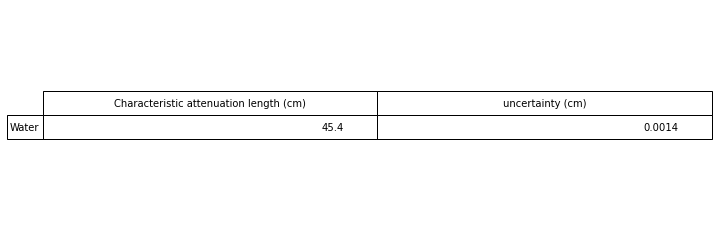

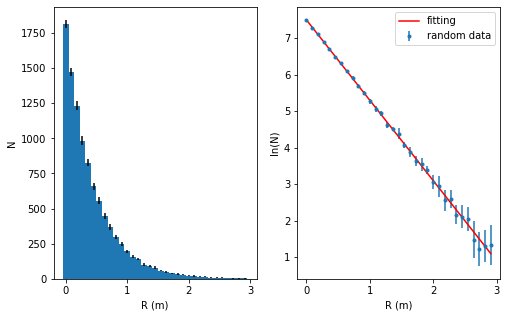

In [9]:
# producing a random exponetial distribution

# setting some parameters to give us results close to the true value, i.e high number of neutrons and iterations
number_of_neutrons = 10000  
nbins = 33
iterations = 10
r_max = 3 # in m

# initialising our histogram array so we can fill it up in a for loop
NR = np.zeros((iterations, nbins))



for i in range(iterations):
    NR[i,:], rbin = np.histogram(-mean_free_path_water * np.log(np.random.uniform(0,1,number_of_neutrons)),
                           bins = nbins, range = (0, r_max )) # generating exponentially distributed lengths as 
                                                              # described in the theory above                                                               
    
rbin = np.delete(rbin, nbins) # we have an extra value of R as each bin is between 2 points, so we need to remove 
                             # one to  make the arrays the same length

# initialising mean and standard deviation arrays, so get a value corresponding to each bin
mean_freq = np.zeros(nbins)
std_freq = np.zeros(nbins)
for i in range(nbins):
    mean_freq[i] = np.mean(NR[:,i])
    std_freq[i] = np.std(NR[:,i])

indices_to_delete_mean = np.where(mean_freq == 0) # we can't have ln(0) so we need to removes the indexes where N = 0
# keeping the arrays the same length
mean_freq = np.delete(mean_freq, indices_to_delete_mean)
std_freq = np.delete(std_freq, indices_to_delete_mean)
rbin = np.delete(rbin, indices_to_delete_mean)

indices_to_delete_std = np.where(std_freq == 0) # so the weighting will work as we divide by standard deviation
mean_freq = np.delete(mean_freq, indices_to_delete_std)
std_freq = np.delete(std_freq, indices_to_delete_std)
rbin = np.delete(rbin, indices_to_delete_std)

# polyfit to get a linear fitting to our data
popt, pcov = np.polyfit(rbin, np.log(mean_freq ),1 , cov = True, w = (mean_freq)/(std_freq))


# calculating attenuation length by the equations stated above
attenuation_length = -1 / popt[0] * 100 # in cm
attenuation_error = (1 / (popt[0]) ** 2) * (pcov[0][0]) * 100

attenuation_data =  [
            [         'Characteristic attenuation length (cm)', 'uncertainty (cm)',],
            ['Water', attenuation_length , attenuation_error,  ],
        ]

# outputting results in a table
create_table(attenuation_data,2,2,'{:4.3}')

# plotting histogram
fig3 = plt.figure(figsize = (8,5))
axhist = plt.subplot(121)
axhist.bar(rbin, mean_freq, rbin[1] - rbin[0], yerr = std_freq)
axhist.set_xlabel('R (m)')
axhist.set_ylabel('N')

# creating fitting data
x_fit = np.linspace(np.min(rbin), np.max(rbin), number_of_neutrons)
y_fit = linear_fitting(popt[0], x_fit, popt[1])
axfit = plt.subplot(122)
axfit.errorbar(rbin, np.log(mean_freq),yerr = (std_freq)/(mean_freq), fmt = '.' ,label = 'random data') 

# plotting fitting
axfit.plot(x_fit, y_fit, c='r', label = 'fitting') # plotting fitted line
axfit.set_xlabel('R (m)')
axfit.set_ylabel('ln(N)')
axfit.legend();

As we can see by the histogram, we get a nice exponential shaped distribution of lengths. Upon calculation of the attenuation length, for 10000 neutrons, we get very close to the expected value of 0.45 m.

## Simulating neutrons in different materials

### Generating isotropic vectors

Now, returning to our complete model, when a neutron is incident on a material, it can either be absorbed, or scattered. We will only consider isotropic scattering, so the neutron has an equal probability of being scattered in any direction after an event. To do this, we will generate points, which are randomly distributed on the surface of a sphere. To do this, we first write our coordinates x, y, z in spherical polar coordinates,<br>
$$ x = r \sin{(\theta)} \cos{(\phi)}, $$ <br> $$ y = r \sin{(\theta)} \sin{(\phi)}, $$ <br> $$ z = r \cos{(\theta)}. $$ <br>
Our first instinct may be to just randomly generate $\theta$ and $\phi$, but as we will see below, this causes issues. Instead, we will only randomly generate $\phi$, and generate $\theta$ by,<br>
$$ \theta = \arccos{(1 - 2u_{i})}$$
where $u_{i}$ is a random number.

In [10]:
def non_isotropic_vectors(r, n):
    """
    Generating what we would think may be n isotropic vectors of length r as stated above, by randomly generating 
    both angles
    Parameters
    ----------
    r: float
    n: integer
    
    Returns
    -------
    x: NumPy array of floats
    y: NumPy array of floats
    z: NumPy array of floats
    """
    # generating theta and phi as random numbers
    theta = np.random.uniform(0,np.pi ,n)
    phi = np.random.uniform(0,2 * np.pi ,n)
    x = []
    y = []
    z = []
    # calculating x, y, z 
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x ,y ,z

def isotropic_vectors(r, n): 
    """
    Generating n isotropic vectors using the method detailed above, of length r
    Parameters
    ----------
    r: float
    n: integer
    
    Returns
    -------
    x: NumPy array of floats
    y: NumPy array of floats
    z: NumPy array of floats
    """
    # generating theta and phi using method stated in the theory above
    theta = np.arccos(1 - 2 * np.random.uniform(0,1 ,n))
    phi = np.random.uniform(0,2 * np.pi ,n)
    x = []
    y = []
    z = []
    # calculating x, y, z 
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta) 
    return x ,y ,z


x_iso, y_iso, z_iso = isotropic_vectors(1,3000) # making 3000 points all of length 1
x_non_iso, y_non_iso, z_non_iso = non_isotropic_vectors(1,3000)
get_ipython().magic('matplotlib notebook') # making the plot interactive
fig4 = plt.figure(figsize = (8,8))

# plotting the non isotropic vectors
ax1 = fig4.add_subplot(1, 2, 1, projection='3d')
ax1.scatter(x_non_iso, y_non_iso, z_non_iso,c = z_non_iso ,marker = '.')
ax1.set_box_aspect((1,1,1))
ax1.set_xlabel('x');
ax1.set_ylabel('y');
ax1.set_zlabel('z');
ax1.set_title('Non isotropic vectors');

# plotting the isotropic vectors
ax2 = fig4.add_subplot(1, 2, 2, projection='3d')
ax2.scatter(x_iso,y_iso,z_iso,c = z_iso ,marker = '.')
ax2.set_box_aspect((1,1,1))
ax2.set_xlabel('x');
ax2.set_ylabel('y');
ax2.set_zlabel('z');
ax2.set_title('Isotropic vectors');


<IPython.core.display.Javascript object>

As we can see by the respective plots, by randomly generating $\theta$ and $\phi$, we get a higher concentration of points at the poles of the sphere to anywhere else, hence we don't have isotropic vectors. By taking $ \theta = \arccos{(1 - 2u_{i})}$, we reduce the concentration of theta in these areas, hence reducing the number of points there, so we obtain a sphere of randomly distributed points across it. If we don't have isotropic vectors, then the scattering won't be random, and so the Monte Carlo method won't work, so it is important we verify this. 

In [11]:
get_ipython().magic('matplotlib inline')  # freezing interactive plots

### Generating exponentially distributed steps

As stated earlier, the step length of the neutrons needs to be exponentially distributed. We do this using the same method as before, setting the step length, r, as, <br>
$$ r = -\lambda \ln{(u_{i})}$$
where again $ u_{i} $ is a random number.

In [12]:
def exp_dist_isotropic_steps(mean_free_path, n):
    """
    Generates n exponentially distributed steps which are isotropic in direction
    Parameters
    ----------
    mean_free_path: float
    n: integer
    
    Returns
    -------
    NumPy array of floats
    """
    # generating the lengths of the vectors
    u = np.random.uniform(0,1,n)
    r = -1 * mean_free_path * np.log(u)
    # setting their direction
    x, y, z = isotropic_vectors(r, n)
    return np.array([x, y, z])

Here we visualise the exponential steps in the form of a histogram.

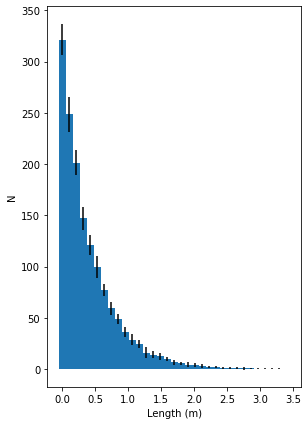

In [13]:
number_of_neutrons = 1500


iterations = 10
nbins = 33
r_max = 3.5 # in m

exp_test = np.zeros((iterations, nbins))

# following the same method as before, creating multiple histograms and taking a mean
for i in range(iterations):
    x_exp, y_exp, z_exp = exp_dist_isotropic_steps(mean_free_path_water, number_of_neutrons);
    lengths = np.sqrt(x_exp ** 2 + y_exp ** 2 + z_exp ** 2)
    exp_test[i,:], rbin = np.histogram(lengths,bins = nbins, range = (0, r_max ))

rbin = np.delete(rbin, nbins)

mean_length = np.zeros(nbins)
std_length = np.zeros(nbins)

for i in range(nbins):
    mean_length[i] = np.mean(exp_test[:,i])
    std_length[i] = np.std(exp_test[:,i])

# plotting the histogram
fig5 = plt.figure(figsize = (10,7));
axhist = plt.subplot(121);
axhist.bar(rbin, mean_length, rbin[1] - rbin[0], yerr = std_length);
axhist.set_xlabel('Length (m)');
axhist.set_ylabel('N');


As we can see by the histogram, the steps are exponentially distributed, so we can use these to generate a random walk for a neutron.

### Total mean free path

Previously, we considered the mean free path in the absence of scattering, but how do we calculate it when we do consider scattering? We simply follow the same procedure as before, but instead of just using the absorption cross section, we combine it with the scattering cross section.

In [14]:
# finding total mean free path

def total_mean_free_path(absorption_coeff, scattering_coeff, atomic_mass, density):
    """
    Calculates the total mean free path for a given material
    Parameters
    ----------
    absorption_coeff: float
    scattering_coeff: float
    atomic_mass: float
    density: float
    
    Returns
    -------
    total_mean_free_path: float
    """
    
    number_density = (density * AVOGADRO_NUMBER) / (atomic_mass * 10 ** (-3))
    transmission_coeff = (absorption_coeff + scattering_coeff) * 10 ** (-28) # in m2 # summing the absorption and 
                                                                             # scattering coefficients to get the total
                                                                             # transmission coefficient
    total_mean_free_path = 1 / (number_density * transmission_coeff) # in m
    return total_mean_free_path



### Absorption Probability

We define the probability that a neutron is absorbed at any interaction as, <br>
$$ P_{a} = \frac{\sigma_{a}}{\sigma_{a} + \sigma_{s}}$$<br>
as the only two outcomes for a neutron at any interaction is absorption or scattering.

In [15]:
def absorption_probability(absorption_coeff, scattering_coeff):
    """
    Calculates the absorption probability for a material
    Parameters
    ----------
    absorption_coeff: float
    scattering_coeff: float
    
    Returns
    -------
    float
    """
    return (absorption_coeff) / (absorption_coeff + scattering_coeff)

Calculating the total mean free path and the absorption probability for each material.

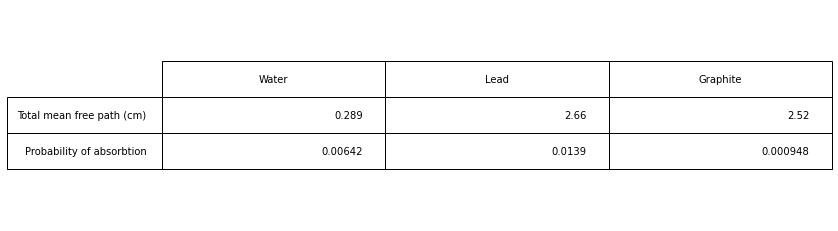

In [16]:
# defining some constants
absorption_coeff_water = 0.6652 # barn
scattering_coeff_water = 103.0 # barn 
atomic_mass_water  = 18.0153 # g/mol
density_water = 1000 #in kg/m^3

absorption_coeff_lead = 0.158 # barn
scattering_coeff_lead = 11.221 # barn
atomic_mass_lead = 207.2 # g/mol
density_lead = 11350 # kg/m^3

absorption_coeff_graphite = 0.0045 # barn
scattering_coeff_graphite = 4.74 # barn
atomic_mass_graphite = 12.011 # g/mol
density_graphite = 1670 # kg/m^3

# calculating the total mean free path for each material using the function defined above
total_mean_free_path_water = total_mean_free_path(absorption_coeff_water, scattering_coeff_water, atomic_mass_water,
                                                 density_water)

total_mean_free_path_lead = total_mean_free_path(absorption_coeff_lead, scattering_coeff_lead, atomic_mass_lead,
                                                density_lead)

total_mean_free_path_graphite = total_mean_free_path(absorption_coeff_graphite, scattering_coeff_graphite,
                                                    atomic_mass_graphite, density_graphite)

# calculating the absorption probability for each material using the function defined above
p_absorption_water = absorption_probability(absorption_coeff_water, scattering_coeff_water)
p_absorption_lead = absorption_probability(absorption_coeff_lead, scattering_coeff_lead)
p_absorption_graphite = absorption_probability(absorption_coeff_graphite, scattering_coeff_graphite)

chemical_constants =  [
            [         'Water', 'Lead', 'Graphite'],
            ['Total mean free path (cm)', total_mean_free_path_water * 100 , 
             total_mean_free_path_lead * 100,   total_mean_free_path_graphite * 100,  ],
            ['Probability of absorbtion',  p_absorption_water, p_absorption_lead,   p_absorption_graphite,  ],
 ]

# outputting these constants in a table so we can check if they're correct
create_table(chemical_constants,3,2,'{:4.3}')

### Visualising a random walk

We have written all the code we need to simulate a random walk for neutron scattering. We start the random walk by stating that the neutron is fired perpendicular to the slab, hence for this step all we need is one exponentially distributed step in the x direction, and y and z are both just 0. Next, we check if the neutron is absorbed after this step. This is done by randomly generating a number between 0 and 1, and comparing it to the absorption probability. We say that if this random number is less than the absorption probability then the neutron has been absorbed. If the neutron is not absorbed, it is then scattered, using the functions created above to determine its x, y and z. We then check again if the neutron has been absorbed after this step, and then we check the neutron's x position, to see if it has left the slab. This is embeded in a while loop, so we keep taking steps until the neutron is either absorbed or has left the slab. We store the current step and the step before it so we can plot a line between its two positions to visualise the walk. We code this all in a function below so it can easily be used for each material.

In [17]:
def perform_random_walk_few_neutrons(num_of_neutrons, mean_free_path, p_absorption, slab_thickness, slab):
    """
    Simulates and visualises a random walk for a small number of neutrons, using the process described above.
    Parameters
    ----------
    num_of_neutrons: integer
    mean_free_path: float
    p_absorption: float
    slab_thickness: float
    slab: string
    
    Returns
    -------
    None
    """
    # creating the figure
    fig_walk = plt.figure(num = 'Random walk in ' + slab, figsize = (5,5))
    ax = Axes3D(fig_walk)
    colour = cm.get_cmap('PiYG', num_of_neutrons) # generating a range of colours for our neutron paths
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_zlabel('z (m)')
    ax.scatter(0,0,0, c = 'green', s = 50) # labelling the start point as the origin      
    
    # initialising some parameters
    max_y = 0
    max_z = 0
    
    min_y = 0
    min_z = 0
    
    num_absorbed = 0
    num_reflected = 0
    num_transmitted = 0  

    for neutron in range(num_of_neutrons):
                
        in_slab = True # setting the neutron as in the slab at the start of the walk
        previous_step = np.array([[1],[0],[0]]) * -1 * mean_free_path * np.log(np.random.uniform(0,1,1))# setting 
        # the initial step as perpendicular to the slab, only in the x direction

                
        ax.plot([previous_step[0][0],0], [previous_step[1][0],0], [previous_step[2][0],0], c = colour(neutron),
                label = 'Neutron ' + str(neutron + 1))
        # plotting the first step as a line from the origin    

        u = np.random.uniform(0,1,1) # generating a number between 0 and 1, then comparing it to the 
        # absorption probability to see if it is absorbed
        if u < p_absorption:
            in_slab = False

        while in_slab == True: # iterating until the neutron leaves the slab, denoted by a boolean value 
            increment = exp_dist_isotropic_steps(mean_free_path, 1);
            step = previous_step + increment # moving the neutron
            
            u = np.random.uniform(0,1,1) # again checking if the neutron got absorbed
            if u < p_absorption:
                in_slab = False
                print('Neutron',neutron + 1,'was absorbed')  

            elif(step[0][0] < 0): # checking if neutron is reflected
                in_slab = False    
                print('Neutron',neutron + 1, 'was reflected')

            elif(step[0][0] > slab_thickness): # checking if neutron is transmitted
                in_slab = False
                print('Neutron',neutron + 1,' was transmitted')
            
            # finding the maximun and minimun y and z we reach so we can plot the slab up to these points
            if step[1][0] > max_y:
                max_y = step[1][0]
            
            if step[1][0] < min_y:
                min_y = step[1][0]

            if step[2][0] > max_z:
                max_z = step[2][0]

            if step[2][0] < min_z:
                min_z = step[2][0]


            ax.plot([previous_step[0][0],step[0][0]], [previous_step[1][0],step[1][0]],
            [previous_step[2][0],step[2][0]],c = colour(neutron))
            # drawing a line from the neutrons postion on the previous iteration to its current position
            previous_step = step
        
        ax.scatter(step[0], step[1], step[2],c = 'red' ,s = 50) # plotting the end of the walk
    
    # creating the slab surface
    y_slab, z_slab  = np.meshgrid(np.linspace(min_y,max_y), np.linspace(min_z, max_z))
    x_slab_start = np.zeros_like(y_slab)
    x_slab_end = slab_thickness * np.ones_like(y_slab)
    ax.plot_surface(x_slab_start, y_slab, z_slab, alpha = 0.2, color = 'b')
    ax.plot_surface(x_slab_end, y_slab, z_slab, alpha = 0.2,color = 'b')
    
    ax.legend();
    plt.show()
    return 

Visualing a random walk in water. The blue surfaces represent the start and the end of the slab, so we can clearly see how the neutron was transmitted or reflected.

In [18]:
#random walk in water for 4 neutrons
material_thickness = 0.1 # in m
number_of_neutrons = 4
iterations = 1
material = 'water'

get_ipython().magic('matplotlib notebook') # making the plot interactive
perform_random_walk_few_neutrons(number_of_neutrons, total_mean_free_path_water, p_absorption_water, material_thickness, material)


<IPython.core.display.Javascript object>

Neutron 1 was reflected
Neutron 2 was reflected
Neutron 3 was reflected
Neutron 4 was reflected


In [19]:
get_ipython().magic('matplotlib inline')  # freezing interactive plots

Visualing a random walk in lead.

In [20]:
#random walk in lead for 4 neutrons
material_thickness = 0.1 # in m
number_of_neutrons = 4
iterations = 1
material = 'lead'

get_ipython().magic('matplotlib notebook') # making the plot interactive
perform_random_walk_few_neutrons(number_of_neutrons, total_mean_free_path_lead, p_absorption_lead, material_thickness, material)

<IPython.core.display.Javascript object>

Neutron 1 was reflected
Neutron 2 was reflected
Neutron 3  was transmitted
Neutron 4 was reflected


In [22]:
get_ipython().magic('matplotlib inline')  # freezing interactive plots

Visualing a random walk in graphite.

<IPython.core.display.Javascript object>


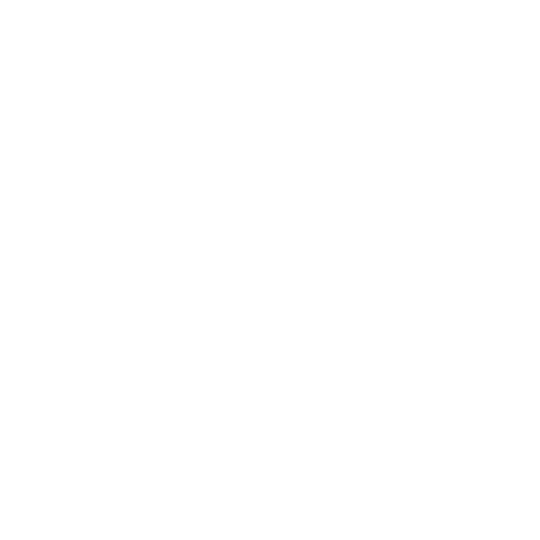

Neutron 1  was transmitted
Neutron 2 was reflected
Neutron 3  was transmitted
Neutron 4  was transmitted


<IPython.core.display.Javascript object>


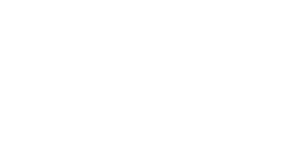

In [23]:
#random walk in graphite for 4 neutron
material_thickness = 0.1 # in m
number_of_neutrons = 4
iterations = 1
material = 'graphite'

get_ipython().magic('matplotlib notebook') # making the plot interactive
perform_random_walk_few_neutrons(number_of_neutrons, total_mean_free_path_graphite, p_absorption_graphite, material_thickness, material)

In [25]:
get_ipython().magic('matplotlib inline')  # freezing interactive plots

From these plots, we verify that the simulation is working correctly, and so we can simulate for many more neutrons, to determine percentages for transmission, absorption and reflection. 

### Random walk for N neutrons

As stated above, we can now simulate the scattering of N neutrons. We obviously don't plot this as it would be impossible to see whats going on. As before we repeat the process of finding the transmission, absorption and reflection percentages, and take a mean and standard deviation of each. Using a for loop to iterate through the number of neutrons here would be one way to do this, but it would be very time consuming as we would be regenerating random steps for each neutron every time. Instead, we generate all of the neutrons at once, storing their x position in an array. We only need the x position as the slab is infinite in the y and z planes so we don't need to check them. Then we follow the same steps as before, just deleting the neutrons that are absorbed, transmitted or reflected. We simply iterate until there are no neutrons left in the array. We will also test how the transmission, absorption and reflection varies, with slab thickness, which is done by simply embedding the code in another loop for each thickness.

We write a function to check and delete the neutrons that are absorbed at each step.

In [26]:
def check_absorbed(p_absorption, num_of_neutrons, array):
    """
    Checks which neutrons from the array are absorbed and deletes them
    Parameters
    ----------
    p_absorption: float
    num_of_neutrons: integer
    array: array
    
    Returns
    -------
    array: array
    """

    u = np.random.uniform(0,1,num_of_neutrons) # generates random number between 0 and 1
    array = np.delete(array,np.where(u < p_absorption)) # deletes all indices corresponding to random number less than
    # the probability as they are 'absorbed'
    return array

Writing the random walk in a function so we can use it for each material.

In [27]:
def perform_random_walk(num_iterations, num_of_neutrons, mean_free_path, p_absorption, slab_thickness):
    """
    Simulates a random walk for many neutrons, using the method described above
    Parameters
    ----------
    num_iterations: integer
    num_of_neutrons: integer
    mean_free_path: float
    p_absorption: float
    slab_thickness: NumPy array of floats
    
    Returns
    -------
    mean_num_absorbed: NumPy array of floats
    mean_num_transmitted: NumPy array of floats
    mean_num_reflected: NumPy array of floats
    num_absorbed_error: NumPy array of floats
    num_transmitted_error: NumPy array of floats
    num_reflected_error: NumPy array of floats
    """
    mean_num_absorbed = np.zeros(len(slab_thickness))
    mean_num_transmitted = np.zeros(len(slab_thickness))
    mean_num_reflected = np.zeros(len(slab_thickness))
    
    num_absorbed_error = np.zeros(len(slab_thickness))
    num_transmitted_error = np.zeros(len(slab_thickness))
    num_reflected_error = np.zeros(len(slab_thickness))
    
        
    for width in range(len(slab_thickness)):  
        num_absorbed = np.zeros(num_iterations)
        num_reflected = np.zeros(num_iterations)
        num_transmitted = np.zeros(num_iterations)
        for i in range(num_iterations):   
            step = -1 * mean_free_path  * np.log(np.random.uniform(0,1,num_of_neutrons)) # generating one x step, whose 
            #length is exponentially distributed, but is perpendicular to the slab, for N neutrons

            step = check_absorbed(p_absorption, len(step), step) # checking which neutrons are absorbed after this step
            

            while len(step) > 0: # iterating until we have no neutrons left in the slab
                
                increment = exp_dist_isotropic_steps(mean_free_path, len(step)); # generating exponentially distributed
                # step lengths, which are isotropic in direction, for however many neutrons we currently have
                step = step + increment[0] # moving the neutrons in the array by this step
                
                step = check_absorbed(p_absorption, len(step), step) # checking which neutrons were absorbed after this 
                #step
                
                num_reflected[i] = num_reflected[i] + np.count_nonzero(step < 0) # counting how many neutrons have been
                #reflected
                num_transmitted[i] = num_transmitted[i] + np.count_nonzero(step > slab_thickness[width]) # counting how
                # many neutrons have been transmitted

                step = np.delete(step,np.where(step < 0)) # removing reflected neutrons from the array
                step = np.delete(step,np.where(step > slab_thickness[width])) # removing transmitted neutrons 
                # from the array

            num_absorbed[i] = num_of_neutrons - num_reflected[i] - num_transmitted[i] # number of absorbed neutrons must be
            # the difference
                
        # finding the mean and standard deviation of each outcome from the iterations  
        mean_num_absorbed[width] = np.mean(num_absorbed)
        num_absorbed_error[width] = np.std(num_absorbed)

        mean_num_transmitted[width] = np.mean(num_transmitted)
        num_transmitted_error[width] = np.std(num_transmitted)

        mean_num_reflected[width] = np.mean(num_reflected)
        num_reflected_error[width] = np.std(num_reflected)
        
    return mean_num_absorbed, mean_num_transmitted, mean_num_reflected, num_absorbed_error, num_transmitted_error, num_reflected_error

Here we will first test each material for one slab of thickness 10 cm, to determine which is the best insulator from neutrons.

In [28]:
#random walk in water for N neutrons

material_thickness = [0.1] # in m
number_of_neutrons = 10000
iterations = 10

# calling the function for water
num_absorbed_water, num_transmitted_water, num_reflected_water,absorbed_error_water, transmitted_error_water, reflected_error_water = perform_random_walk(iterations,number_of_neutrons
                                                                                     ,total_mean_free_path_water,
                                                                                    p_absorption_water, 
                                                                                     material_thickness)


In [29]:
#random walk in lead for N neutrons

material_thickness = [0.1] # in m
number_of_neutrons = 10000
iterations = 10

# calling the function for lead
num_absorbed_lead, num_transmitted_lead, num_reflected_lead,absorbed_error_lead, transmitted_error_lead, reflected_error_lead = perform_random_walk(iterations,number_of_neutrons
                                                                                     ,total_mean_free_path_lead,
                                                                                    p_absorption_lead, 
                                                                                     material_thickness)


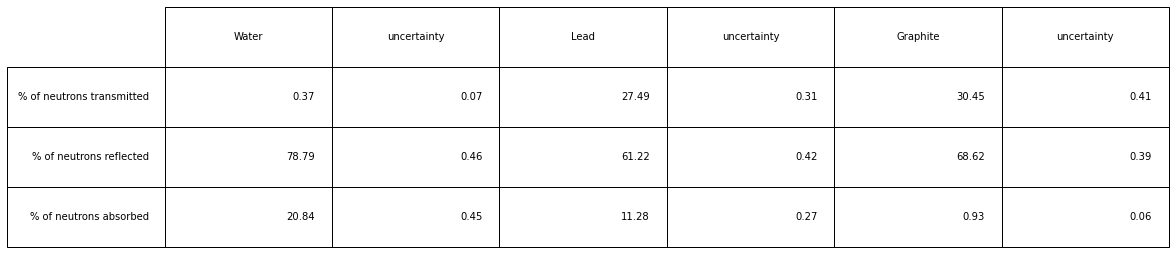

In [30]:
#random walk in graphite for N neutrons

material_thickness = [0.1] # in m
number_of_neutrons = 10000
iterations = 10

# calling the function for graphite
num_absorbed_graphite, num_transmitted_graphite, num_reflected_graphite,absorbed_error_graphite, transmitted_error_graphite, reflected_error_graphite = perform_random_walk(iterations,number_of_neutrons
                                                                                     ,total_mean_free_path_graphite,
                                                                                    p_absorption_graphite, 
                                                                                     material_thickness)

# calculating percentages
percentage_absorbed_water = (num_absorbed_water[0] / number_of_neutrons)  * 100
percentage_absorbed_error_water = (absorbed_error_water[0] / number_of_neutrons) * 100
percentage_reflected_water = (num_reflected_water[0] / number_of_neutrons)  * 100
percentage_reflected_error_water = (reflected_error_water[0] / number_of_neutrons) * 100
percentage_transmitted_water = (num_transmitted_water[0] / number_of_neutrons) * 100
percentage_transmitted_error_water = (transmitted_error_water[0] / number_of_neutrons) * 100

percentage_absorbed_lead = (num_absorbed_lead[0] / number_of_neutrons)  * 100
percentage_absorbed_error_lead = (absorbed_error_lead[0] / number_of_neutrons) * 100
percentage_reflected_lead = (num_reflected_lead[0] / number_of_neutrons)  * 100
percentage_reflected_error_lead = (reflected_error_lead[0] / number_of_neutrons) * 100
percentage_transmitted_lead = (num_transmitted_lead[0] / number_of_neutrons)  * 100
percentage_transmitted_error_lead = (transmitted_error_lead[0] / number_of_neutrons) * 100

percentage_absorbed_graphite = (num_absorbed_graphite[0] / number_of_neutrons)  * 100
percentage_absorbed_error_graphite = (absorbed_error_graphite[0] / number_of_neutrons) * 100
percentage_reflected_graphite = (num_reflected_graphite[0] / number_of_neutrons)  * 100
percentage_reflected_error_graphite = (reflected_error_graphite[0] / number_of_neutrons) * 100 
percentage_transmitted_graphite = (num_transmitted_graphite[0] / number_of_neutrons) * 100
percentage_transmitted_error_graphite = (transmitted_error_graphite[0] / number_of_neutrons) * 100

random_walk_data =  [
            [         'Water','uncertainty' ,'Lead','uncertainty', 'Graphite','uncertainty'],
            ['% of neutrons transmitted',  percentage_transmitted_water, percentage_transmitted_error_water,
             percentage_transmitted_lead, percentage_transmitted_error_lead, 
             percentage_transmitted_graphite, percentage_transmitted_error_graphite],
            ['% of neutrons reflected',  percentage_reflected_water, percentage_reflected_error_water,
             percentage_reflected_lead, percentage_reflected_error_lead ,
             percentage_reflected_graphite, percentage_reflected_error_graphite ],
            ['% of neutrons absorbed',  percentage_absorbed_water, percentage_absorbed_error_water,
             percentage_absorbed_lead, percentage_absorbed_error_lead,
             percentage_absorbed_graphite, percentage_absorbed_error_graphite ],
        ]
# outputting the results in a table
create_table(random_walk_data,5,3, '{0:4.2f}')

From the table, we can clearly see that water is the best insulator against thermal neutrons. Lead and graphite had fairly similar transmission percentages, but lead had a much higher absorption rate than graphite, making it a better insulator.

### Simulating a random walk for different slab thicknesses

We will now test how these percentages vary with thickness of slab, so we can determine what thickness of each material is required to get a small number of neutrons transmitted. Here we generate the thicknesses using np.geomspace, which generates evenly spaced points on a log scale, matching our distribution. Also, using the data from the different thicknesses, we can determine the characteristic attenuation length of each material.

In [31]:
#random walk for different slab widths of water
material_thickness_water = np.geomspace(0.001,0.02,20) # producing different thicknesses
number_of_neutrons = 10000
iterations = 10

# calling the function
num_absorbed_water, num_transmitted_water, num_reflected_water,absorbed_error_water, transmitted_error_water, reflected_error_water = perform_random_walk(iterations,number_of_neutrons
                                                                                     ,total_mean_free_path_water,
                                                                                    p_absorption_water, 
                                                                                       material_thickness_water)
# calculating ratios
absorbed_ratio_water = num_absorbed_water / number_of_neutrons
reflected_ratio_water = num_reflected_water / number_of_neutrons
transmitted_ratio_water = num_transmitted_water / number_of_neutrons





In [32]:
#random walk for different slab widths of lead
material_thickness_lead = np.geomspace(0.01,0.2,20)
number_of_neutrons = 10000
iterations = 10

# calling the function
num_absorbed_lead, num_transmitted_lead, num_reflected_lead,absorbed_error_lead, transmitted_error_lead, reflected_error_lead = perform_random_walk(iterations,number_of_neutrons
                                                                                     ,total_mean_free_path_lead,
                                                                                    p_absorption_lead, 
                                                                                     material_thickness_lead)
# calculating ratios
absorbed_ratio_lead = num_absorbed_lead / number_of_neutrons
reflected_ratio_lead = num_reflected_lead/ number_of_neutrons
transmitted_ratio_lead = num_transmitted_lead / number_of_neutrons


In [33]:
#random walk for different slab widths of graphite
material_thickness_graphite = np.geomspace(0.01,0.2,20)
number_of_neutrons = 10000
iterations = 10

# calling the function
num_absorbed_graphite, num_transmitted_graphite, num_reflected_graphite,absorbed_error_graphite, transmitted_error_graphite, reflected_error_graphite = perform_random_walk(iterations,number_of_neutrons
                                                                                     ,total_mean_free_path_graphite,
                                                                                    p_absorption_graphite, 
                                                                                     material_thickness_graphite)
# calculating ratios
absorbed_ratio_graphite = num_absorbed_graphite / number_of_neutrons
reflected_ratio_graphite = num_reflected_graphite/ number_of_neutrons
transmitted_ratio_graphite = num_transmitted_graphite / number_of_neutrons


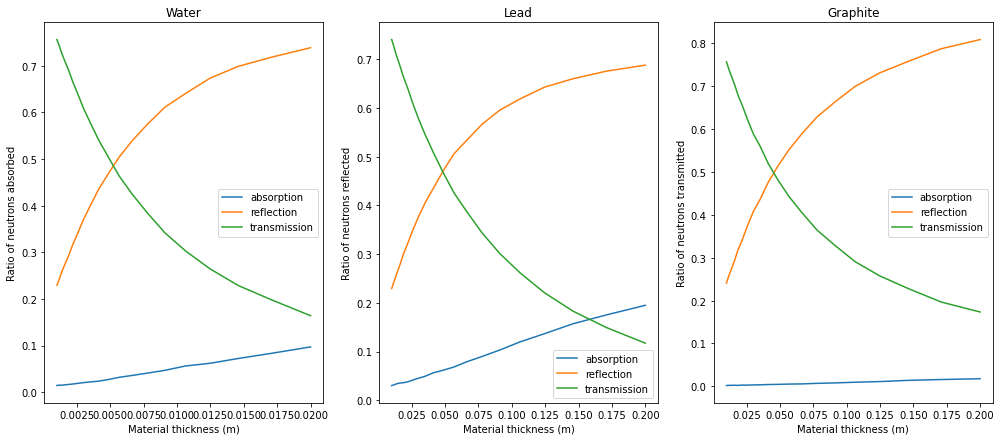

In [34]:
# plotting these results
fig_thickness = plt.figure(figsize = (17,7));
ax_water = plt.subplot(131)
ax_lead = plt.subplot(132)
ax_graphite = plt.subplot(133)

# creating plot for water
ax_water.plot(material_thickness_water, absorbed_ratio_water, label = 'absorption')
ax_water.plot(material_thickness_water, reflected_ratio_water, label = 'reflection')
ax_water.plot(material_thickness_water, transmitted_ratio_water, label = 'transmission')
ax_water.set_xlabel('Material thickness (m)')
ax_water.set_ylabel('Ratio of neutrons absorbed')
ax_water.set_title('Water')
ax_water.legend();

# creating plot for lead
ax_lead.plot(material_thickness_lead, absorbed_ratio_lead, label = 'absorption')
ax_lead.plot(material_thickness_lead, reflected_ratio_lead, label = 'reflection')
ax_lead.plot(material_thickness_lead, transmitted_ratio_lead, label = 'transmission')
ax_lead.set_xlabel('Material thickness (m)')
ax_lead.set_ylabel('Ratio of neutrons reflected')
ax_lead.set_title('Lead')
ax_lead.legend();

# creating plot for graphite
ax_graphite.plot(material_thickness_graphite, absorbed_ratio_graphite, label = 'absorption')
ax_graphite.plot(material_thickness_graphite, reflected_ratio_graphite, label = 'reflection')
ax_graphite.plot(material_thickness_graphite, transmitted_ratio_graphite, label = 'transmission')
ax_graphite.set_xlabel('Material thickness (m)')
ax_graphite.set_ylabel('Ratio of neutrons transmitted')
ax_graphite.set_title('Graphite')
ax_graphite.legend();

From these plots, we can see that after about 5 cm of water, there os not much change in the rates of transmission, reflection and absorption. For lead and graphite however, they only start to level out after 20 cm.

### Determining attenuation length.

If we take the log of the number of transmitted neutrons, we can then plot this against the material thickness to find the characteristic attenuation length. The attenuation length is again related to the gradient of this plot by,<br>
$$ \lambda = -\frac{1}{m} $$<br>
just like the case we considered for water earlier in the project. We weight the polyfitting by number of neutrons divided by the standard deviation, similar to the previous fitting.

For the fitting to work, we need to remove any thicknesses that had no transmission, and ones which had no standard deviation. 

In [33]:
# in order to do a poly fitting, we need to remove thickness that transmitted no neutrons, or had no standard deviation

# for water
water_indices_to_delete_mean = np.where(num_transmitted_water == 0)
num_transmitted_water = np.delete(num_transmitted_water, water_indices_to_delete_mean)
transmitted_error_water = np.delete(transmitted_error_water, water_indices_to_delete_mean)
material_thickness_water = np.delete(material_thickness_water, water_indices_to_delete_mean)

water_indices_to_delete_std = np.where(transmitted_error_water == 0)
num_transmitted_water = np.delete(num_transmitted_water, water_indices_to_delete_std)
transmitted_error_water = np.delete(transmitted_error_water, water_indices_to_delete_std)
material_thickness_water = np.delete(material_thickness_water, water_indices_to_delete_std)

# for lead
lead_indices_to_delete_mean = np.where(num_transmitted_lead == 0)
num_transmitted_lead = np.delete(num_transmitted_lead, lead_indices_to_delete_mean)
transmitted_error_lead = np.delete(transmitted_error_lead, lead_indices_to_delete_mean)
material_thickness_lead = np.delete(material_thickness_lead, lead_indices_to_delete_mean)

lead_indices_to_delete_std = np.where(transmitted_error_lead == 0)
num_transmitted_lead = np.delete(num_transmitted_lead, lead_indices_to_delete_std)
transmitted_error_lead = np.delete(transmitted_error_lead, lead_indices_to_delete_std)
material_thickness_lead = np.delete(material_thickness_lead, lead_indices_to_delete_std)

# for graphite
graphite_indices_to_delete_mean = np.where(num_transmitted_graphite == 0)
num_transmitted_graphite = np.delete(num_transmitted_graphite, graphite_indices_to_delete_mean)
transmitted_error_graphite = np.delete(transmitted_error_graphite, graphite_indices_to_delete_mean)
material_thickness_graphite = np.delete(material_thickness_graphite, graphite_indices_to_delete_mean)

graphite_indices_to_delete_std = np.where(transmitted_error_graphite == 0)
num_transmitted_graphite = np.delete(num_transmitted_graphite, graphite_indices_to_delete_std)
transmitted_error_graphite = np.delete(transmitted_error_graphite, graphite_indices_to_delete_std)
material_thickness_graphite = np.delete(material_thickness_graphite, graphite_indices_to_delete_std)

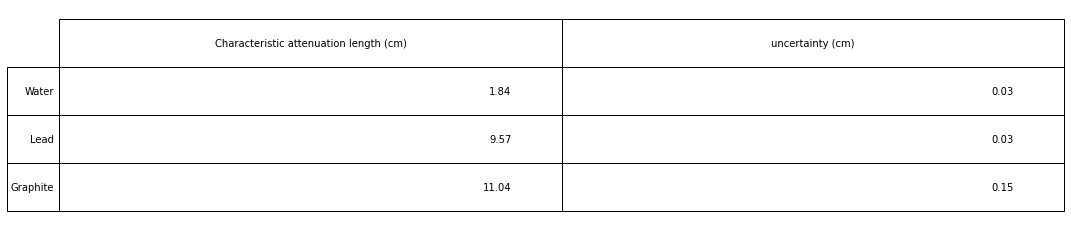

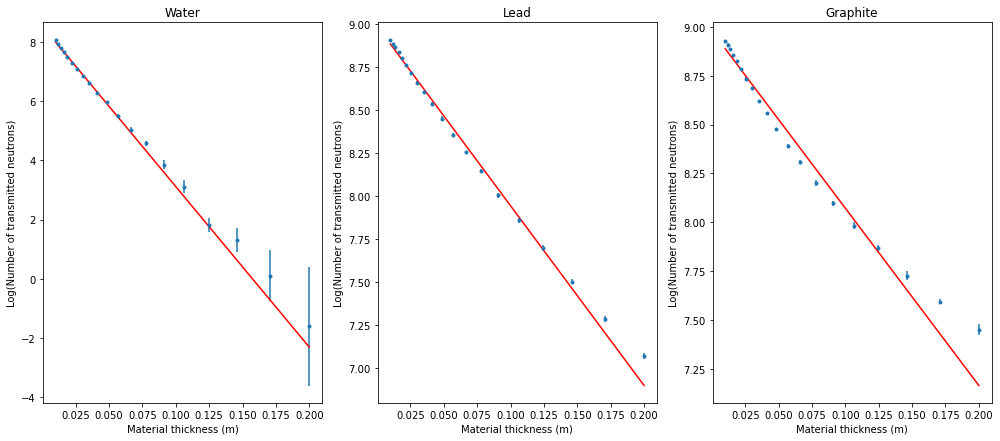

In [34]:
# determining the attenuation lengths

coeff_water, covar_water = np.polyfit(material_thickness_water, np.log(num_transmitted_water), 1 ,cov = True , 
                          w = (num_transmitted_water / transmitted_error_water))

coeff_lead, covar_lead = np.polyfit(material_thickness_lead, np.log(num_transmitted_lead), 1 ,cov = True , 
                          w = (num_transmitted_lead / transmitted_error_lead))

coeff_graphite, covar_graphite = np.polyfit(material_thickness_graphite, np.log(num_transmitted_graphite), 1 ,cov = True , 
                          w = (num_transmitted_graphite / transmitted_error_graphite))

water_fit = linear_fitting(coeff_water[0], material_thickness_water, coeff_water[1])
lead_fit = linear_fitting(coeff_lead[0], material_thickness_lead, coeff_lead[1])
graphite_fit = linear_fitting(coeff_graphite[0], material_thickness_graphite, coeff_graphite[1])

characteristic_attenuation_length_water = -1 / coeff_water[0] * 100
characteristic_attenuation_length_water_error  = (1 / (coeff_water[0] ** 2)) * covar_water[0][0] * 100

characteristic_attenuation_length_lead = -1 / coeff_lead[0] * 100
characteristic_attenuation_length_lead_error = (1 / (coeff_lead[0] ** 2)) * covar_lead[0][0] * 100

characteristic_attenuation_length_graphite = -1 / coeff_graphite[0] * 100
characteristic_attenuation_length_graphite_error = (1 / (coeff_graphite[0] ** 2)) * covar_graphite[0][0] * 100 

# table data
attenuation_data =  [
            [         'Characteristic attenuation length (cm)', 'uncertainty (cm)',],
            ['Water', characteristic_attenuation_length_water , characteristic_attenuation_length_water_error,  ],
            ['Lead',  characteristic_attenuation_length_lead, characteristic_attenuation_length_lead_error,],
            ['Graphite',characteristic_attenuation_length_graphite,characteristic_attenuation_length_graphite_error, ],
        ]
# plotting table
create_table(attenuation_data,4,3, '{0:4.2f}');

# plotting fits
fig_attenution_length = plt.figure(figsize = (17,7))

ax_water = plt.subplot(131)
ax_water.set_xlabel('Material thickness (m)')
ax_water.set_ylabel('Log(Number of transmitted neutrons)')
ax_water.set_title('Water')

ax_lead = plt.subplot(132)
ax_lead.set_xlabel('Material thickness (m)')
ax_lead.set_ylabel('Log(Number of transmitted neutrons)')
ax_lead.set_title('Lead')

ax_graphite = plt.subplot(133)
ax_graphite.set_xlabel('Material thickness (m)')
ax_graphite.set_ylabel('Log(Number of transmitted neutrons)')
ax_graphite.set_title('Graphite')

ax_water.errorbar(material_thickness_water, np.log(num_transmitted_water),
                  yerr = (transmitted_error_water)/(num_transmitted_water), fmt = '.' ,label = 'random data water') 
ax_water.plot(material_thickness_water, water_fit, c='r', label = 'fitting'); # plotting fitted line

ax_lead.errorbar(material_thickness_lead, np.log(num_transmitted_lead),
                  yerr = (transmitted_error_lead)/(num_transmitted_lead), fmt = '.' ,label = 'random data lead') 
ax_lead.plot(material_thickness_lead, lead_fit, c='r', label = 'fitting'); # plotting fitted line

ax_graphite.errorbar(material_thickness_graphite, np.log(num_transmitted_graphite),
                  yerr = (transmitted_error_graphite)/(num_transmitted_graphite), fmt = '.' ,
                     label = 'random data graphite') 
ax_graphite.plot(material_thickness_graphite, graphite_fit, c='r', label = 'fitting'); # plotting fitted line

As expected from the earlier plots, water had the shortest attenuation length, followed by lead, the graphite.

## Woodcock Method

Sometimes, we want to investigate the absorption of material slabs that are not isolated, and have boundaries with other materials. This could be useful in cases like radiotherapy, where we need to see where layers of tissue will absorb the radiation. The two materials will have two different mean free paths, and so when we cross the boundary between them, we could calculate what portion of that step was in each material, and use the given mean free path for each, then apply the method we have been using throughout this project. This calculation is very difficult, and so instead we use the Woodcock method. This works by setting the shortest mean free path of the two materials as the total mean free path for the slab. So the steps will be correct in one material, but too short in the other. To fix this, we introduce fictitious steps. Fictitious steps do nothing but move the neutron in the same direction it was travelling in, it cannot be absorbed nor scattered. We set the probability of there being a fictitious step as,<br>
$$ P_{f} = \frac{\Sigma_{i}}{\Sigma_{max}}$$
where $\Sigma_{max}$ is the macroscopic cross section of the total slab $=\frac{1}{\lambda}$, and $\Sigma_{i}$ is the macroscopic cross section of the material we're in. We say we get fictitious steps when a random number generated between 0 and 1 is greater than $P_{f}$. So, for one material we get no fictitious steps. We then follow a similar process to as before. We generate N exponentially distributed step lengths, move a step, then check absorption. We then check which neutrons move fictitious steps. For those that don't, we then scatter, but we generate the lengths and directions separately, as the directions are needed for the fictitious steps, so we can't use the functions from before, the method is the same though. For the steps that are ficitious, we override the new angles with the previous ones. We then check if any neutrons have been reflected or transmiited. This is actually placed at the start of the loop, but logically it comes here. Then as before, we iterate until there are no neutrons left in the slab.

In [35]:
def perform_random_walk_woodcock(num_iterations, num_of_neutrons, macro_x_section1, macro_x_section2, 
                                 p_absorption1, p_absorption2, slab_thickness):

    """
    Simulates a random walk for many neutrons through two different materials, using the method Woodcock described 
    in the theory above.
    Parameters
    ----------
    num_iterations: integer
    num_of_neutrons: integer
    macro_x_section1: float
    macro_x_section2: float
    p_absorption1: float
    p_absorption2: float
    slab_thickness: float
    
    Returns
    -------
    mean_num_absorbed: float
    mean_num_transmitted: float
    mean_num_reflected: float
    num_absorbed_error: float
    num_transmitted_error: float
    num_reflected_error: float
    """
    mean_num_transmitted = 0
    num_transmitted_error = 0
    
    mean_num_absorbed = 0
    num_absorbed_error = 0
    
    mean_num_reflected = 0
    num_reflected_error = 0
    
    num_transmitted = np.zeros(num_iterations)
    num_reflected = np.zeros(num_iterations)
    num_absorbed = np.zeros(num_iterations)
    macro_x_section = np.max([macro_x_section1,macro_x_section2]) # setting the macro cross section we use as the
    # largest of the two cross sections
    
    mean_free_path = 1 / macro_x_section # setting the mean free path we use for both materials
    
    probability_no_fictitious_slab1 = macro_x_section1 / macro_x_section
    probability_no_fictitious_slab2 = macro_x_section2 / macro_x_section
    
    for i in range(num_iterations): 
        
        step = -1 * mean_free_path  * np.log(np.random.uniform(0,1,num_of_neutrons)) # generating N steps all
        # perpendicular to the slab as before
        theta  = np.ones(num_of_neutrons) * np.pi / 2 
        phi = np.zeros(num_of_neutrons)

        while len(step) > 0: # iterating until no neutrons are left in the slabs as before 
            
            # checking and deleting reflected and transmitted
            num_reflected[i] = num_reflected[i] + np.count_nonzero(step < 0) # counting how many neutrons have been
            #reflected
            num_transmitted[i] = num_transmitted[i] + np.count_nonzero(step > slab_thickness * 2) # counting how
            
            num_absorbed[i] = num_of_neutrons - num_reflected[i] - num_transmitted[i] # number of absorbed neutrons must be
            # the difference
            
            # delete neutrons have been transmitted and reflected
            indices_to_delete_reflection = np.where((step < 0))
            indices_to_delete_transmittion = np.where((step > slab_thickness * 2))
            indices_to_delete = np.hstack((indices_to_delete_reflection,indices_to_delete_transmittion))
            step = np.delete(step,indices_to_delete) # removing reflected neutrons from the array
            theta = np.delete(theta, indices_to_delete) # keeping arrays the same length
            phi = np.delete(phi, indices_to_delete)
            
            # checking fictitious steps
            u = np.random.uniform(0, 1, len(step))
            
            fictitious_slab1 = np.where((step > 0) & (step < slab_thickness) & (u > probability_no_fictitious_slab1))
            fictitious_slab2 = np.where((step > slab_thickness) & (step < 2 * slab_thickness) & (u > probability_no_fictitious_slab2))
            # one of these will return 0 depending on which slab allows for fictitious steps
            
            fictitious_steps_indices = np.hstack((fictitious_slab1, fictitious_slab2))
            
            # checked absorbed
            
            u = np.random.uniform(0, 1, len(step))
            absorbed_indices_slab1 = np.where((step > 0) & (step < slab_thickness) & (u < p_absorption1))
            absorbed_indices_slab2 = np.where((step > slab_thickness) & (step < 2 * slab_thickness) & (u < p_absorption2))
            absorbed_indices = np.hstack((absorbed_indices_slab2, absorbed_indices_slab1))
            

            absorbed_indices = np.delete(absorbed_indices, np.nonzero(np.in1d(absorbed_indices, fictitious_steps_indices))) 
            # we can't absorb on a fictitious step so we remove all of these indices so they are not absorbed

            # scattering
            increment = -1 * mean_free_path  * np.log(np.random.uniform(0,1,len(step))) 
            
            # generate new angles for each step as described before
            proposed_theta = np.arccos(1 - 2 * np.random.uniform(0,1 ,len(step)))
            proposed_phi = np.random.uniform(0,2 * np.pi ,len(step))
            

            
            # need to override this for fictitious steps as they are in the same direction
            proposed_theta[fictitious_steps_indices] = theta[fictitious_steps_indices]
            proposed_phi[fictitious_steps_indices] = phi[fictitious_steps_indices]
            
            #setting the new angles
            theta = proposed_theta
            phi = proposed_phi
            
            # apply direction to the steps
            increment = increment * np.sin(theta) * np.cos(phi)
            
            step = step + increment
            
            # now removing all the absorbed neutrons, we do this here otherwise the lengths of the arrays changes and we
            # can't do the previous step
            step = np.delete(step, absorbed_indices)
            theta = np.delete(theta, absorbed_indices)
            phi = np.delete(phi, absorbed_indices)
            
    # taking means and standard deviations over iterations as done previously
    
    mean_num_absorbed = np.mean(num_absorbed)
    num_absorbed_error = np.std(num_absorbed)

    mean_num_transmitted = np.mean(num_transmitted)
    num_transmitted_error = np.std(num_transmitted)
        
    mean_num_reflected = np.mean(num_reflected)
    num_reflected_error = np.std(num_reflected)
        

        
    return mean_num_absorbed, mean_num_transmitted, mean_num_reflected, num_absorbed_error, num_transmitted_error, num_reflected_error

Defining some constants we will use for the Woodcock method

In [36]:
macro_x_section_water = 1 / total_mean_free_path_water

macro_x_section_lead = 1 / total_mean_free_path_lead

macro_x_section_graphite = 1 / total_mean_free_path_graphite

To test if the method is working correctly, we can set one of the materials as a vacuum, with a macroscopic cross section and probability of absorption both as 0. Then we can compare the results we get to those calculated previously, as they should be roughly the same, accounting for the randomness of the data.

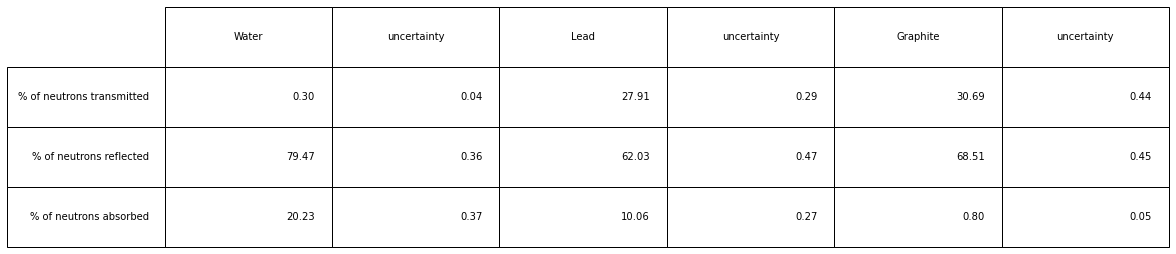

In [37]:
number_of_neutrons = 10000
iterations = 10
material_thickness = 0.1 # in m

# testing water with a vacuum
woodcock_absorbed_water, woodcock_transmitted_water, woodcock_reflected_water, woodcock_absorbed_water_error, woodcock_transmitted_water_error, woodcock_reflected_water_error =  perform_random_walk_woodcock(iterations, number_of_neutrons, 0,  
                                                               macro_x_section_water, 0, p_absorption_water, 
                                                               material_thickness)
# testing lead with a vacuum
woodcock_absorbed_lead, woodcock_transmitted_lead, woodcock_reflected_lead, woodcock_absorbed_lead_error, woodcock_transmitted_lead_error, woodcock_reflected_lead_error =  perform_random_walk_woodcock(iterations, number_of_neutrons, 0,  
                                                               macro_x_section_lead, 0, p_absorption_lead, 
                                                               material_thickness)
# testing graphite with a vacuum
woodcock_absorbed_graphite, woodcock_transmitted_graphite, woodcock_reflected_graphite, woodcock_absorbed_graphite_error, woodcock_transmitted_graphite_error, woodcock_reflected_graphite_error =  perform_random_walk_woodcock(iterations, number_of_neutrons, 0,  
                                                               macro_x_section_graphite, 0, p_absorption_graphite, 
                                                               material_thickness)


# calculating percentages
percentage_absorbed_water = (woodcock_absorbed_water / number_of_neutrons)  * 100
percentage_absorbed_error_water = (woodcock_absorbed_water_error / number_of_neutrons) * 100
percentage_reflected_water = (woodcock_reflected_water / number_of_neutrons)  * 100
percentage_reflected_error_water = (woodcock_reflected_water_error / number_of_neutrons) * 100
percentage_transmitted_water = (woodcock_transmitted_water / number_of_neutrons) * 100
percentage_transmitted_error_water = (woodcock_transmitted_water_error / number_of_neutrons) * 100

percentage_absorbed_lead = (woodcock_absorbed_lead / number_of_neutrons)  * 100
percentage_absorbed_error_lead = (woodcock_absorbed_lead_error / number_of_neutrons) * 100
percentage_reflected_lead = (woodcock_reflected_lead / number_of_neutrons)  * 100
percentage_reflected_error_lead = (woodcock_reflected_lead_error / number_of_neutrons) * 100
percentage_transmitted_lead = (woodcock_transmitted_lead / number_of_neutrons)  * 100
percentage_transmitted_error_lead = (woodcock_transmitted_lead_error / number_of_neutrons) * 100

percentage_absorbed_graphite = (woodcock_absorbed_graphite / number_of_neutrons)  * 100
percentage_absorbed_error_graphite = (woodcock_absorbed_graphite_error / number_of_neutrons) * 100
percentage_reflected_graphite = (woodcock_reflected_graphite / number_of_neutrons)  * 100
percentage_reflected_error_graphite = (woodcock_reflected_graphite_error / number_of_neutrons) * 100 
percentage_transmitted_graphite = (woodcock_transmitted_graphite/ number_of_neutrons) * 100
percentage_transmitted_error_graphite = (woodcock_transmitted_graphite_error / number_of_neutrons) * 100

random_walk_data =  [
            [         'Water','uncertainty' ,'Lead','uncertainty', 'Graphite','uncertainty'],
            ['% of neutrons transmitted',  percentage_transmitted_water, percentage_transmitted_error_water,
             percentage_transmitted_lead, percentage_transmitted_error_lead, 
             percentage_transmitted_graphite, percentage_transmitted_error_graphite],
            ['% of neutrons reflected',  percentage_reflected_water, percentage_reflected_error_water,
             percentage_reflected_lead, percentage_reflected_error_lead ,
             percentage_reflected_graphite, percentage_reflected_error_graphite ],
            ['% of neutrons absorbed',  percentage_absorbed_water, percentage_absorbed_error_water,
             percentage_absorbed_lead, percentage_absorbed_error_lead,
             percentage_absorbed_graphite, percentage_absorbed_error_graphite ],
        ]

# outputting data in a table
create_table(random_walk_data,5,3, '{0:4.2f}')


As we can see by the table above, this produces the same results as our earlier method, so we can assume the Woodcock method is working correctly and now test the transmission of two materials side by side.

Now, we can test for different combinations of materials. We test both lead and graphite with water, and then with each other. We place water second as it has a low transmission percentage, so we won't get many neutrons entering the second material if we place it first. 

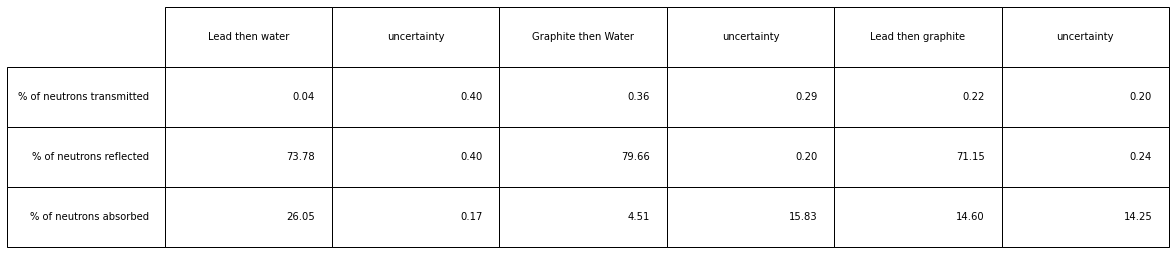

In [38]:
# testing lead then water
lead_water_absorption, lead_water_absorption_error, lead_water_reflection, lead_water_reflection_error, lead_water_transmission, lead_water_transmission_error = perform_random_walk_woodcock(iterations, 
number_of_neutrons,macro_x_section_lead, macro_x_section_water, p_absorption_lead, p_absorption_water, 
material_thickness) 

# testing graphite then water
graphite_water_absorption, graphite_water_absorption_error, graphite_water_reflection, graphite_water_reflection_error, graphite_water_transmission, graphite_water_transmission_error = perform_random_walk_woodcock(iterations, 
number_of_neutrons,macro_x_section_lead, macro_x_section_graphite, p_absorption_graphite, p_absorption_water, 
material_thickness)

# testing lead then graphite
lead_graphite_absorption, lead_graphite_absorption_error, lead_graphite_reflection, lead_graphite_reflection_error, lead_graphite_transmission, lead_graphite_transmission_error = perform_random_walk_woodcock(iterations,
number_of_neutrons,macro_x_section_lead, macro_x_section_graphite, p_absorption_lead, p_absorption_graphite,
material_thickness)

# calculating percentages
percentage_absorbed_lw = (lead_water_absorption / number_of_neutrons)  * 100
percentage_absorbed_error_lw = (lead_water_absorption_error / number_of_neutrons) * 100
percentage_reflected_lw = (lead_water_reflection / number_of_neutrons)  * 100
percentage_reflected_error_lw = (lead_water_reflection_error / number_of_neutrons) * 100
percentage_transmitted_lw = (lead_water_transmission / number_of_neutrons) * 100
percentage_transmitted_error_lw = (lead_water_transmission_error / number_of_neutrons) * 100

percentage_absorbed_gw = (graphite_water_absorption / number_of_neutrons)  * 100
percentage_absorbed_error_gw = (graphite_water_absorption_error / number_of_neutrons) * 100
percentage_reflected_gw = (graphite_water_reflection / number_of_neutrons)  * 100
percentage_reflected_error_gw = (graphite_water_reflection_error / number_of_neutrons) * 100
percentage_transmitted_gw = (graphite_water_transmission / number_of_neutrons)  * 100
percentage_transmitted_error_gw = (graphite_water_transmission_error / number_of_neutrons) * 100

percentage_absorbed_lg = (lead_graphite_absorption / number_of_neutrons)  * 100
percentage_absorbed_error_lg = (lead_graphite_absorption_error / number_of_neutrons) * 100
percentage_reflected_lg = (lead_graphite_reflection / number_of_neutrons)  * 100
percentage_reflected_error_lg = (lead_graphite_reflection_error / number_of_neutrons) * 100 
percentage_transmitted_lg = (lead_graphite_transmission/ number_of_neutrons) * 100
percentage_transmitted_error_lg = (lead_graphite_transmission_error / number_of_neutrons) * 100

random_walk_data =  [
            [         'Lead then water','uncertainty' ,'Graphite then Water','uncertainty', 'Lead then graphite',
             'uncertainty'],
            ['% of neutrons transmitted', percentage_transmitted_lw ,percentage_transmitted_error_lw ,
             percentage_transmitted_gw, percentage_transmitted_error_gw, 
             percentage_transmitted_lg, percentage_transmitted_error_lg],
            ['% of neutrons reflected',percentage_reflected_lw  ,percentage_reflected_error_lw ,
             percentage_reflected_gw, percentage_reflected_error_gw ,
             percentage_reflected_lg, percentage_reflected_error_lg ],
            ['% of neutrons absorbed',  percentage_absorbed_lw, percentage_absorbed_error_lw,
             percentage_absorbed_gw, percentage_absorbed_error_gw,
             percentage_absorbed_lg, percentage_absorbed_error_lg ],
        ]

# outputting data in a table
create_table(random_walk_data,5,3, '{0:4.2f}')

From this data, we see that combinations of the solids with water results in very low transmission, but only a small improvement over a layer of just water. But, water can only really be used as a shield in very specific senarios, as it is a liquid. We see that a combination of lead and graphite also gives a very low transmission rate, and would be a much easier shield to work with compared to one containing water, if we wanted to protect ourselves from thermal neutrons. 

## Conclusions

In conclusion, we found, using Monte Carlo simulations, that of water, lead and graphite, water was the best shielder of thermal neutrons and graphite the worst. We only considered neutrons which could undergo isotropic scattering, or be absorbed. We also determined the characteristic attenuation length for each material. When considering a combination of two materials, using the Woodcock method, we found that combining water with either material gave little improvement, but combining the two solids greatly reduced the transmission percentage, making a combination of lead and graphite an optimal shielding layer.